# Entrono #

In [69]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import GradientBoostingRegressor

# Imports para agente de recolección de datos
import yfinance as yf
import pandas as pd
import ta
from datetime import datetime, timedelta
import seaborn as sns
from IPython.display import clear_output

# 

In [70]:
# ----------------------------
# Pub/Sub Broker
# ----------------------------
class PubSubBroker:
    def __init__(self):
        self.subscribers = []

    def subscribe(self, callback):
        self.subscribers.append(callback)

    def publish(self, data):
        for callback in self.subscribers:
            callback(data)

# ----------------------------
# Whiteboard (memoria compartida)
# ----------------------------
class Whiteboard:
    def __init__(self):
        self.data = {}

    def write(self, key, value):
        self.data[key] = value

    def read(self):
        while len(self.data) < 2:
            print("Esperando datos en la pizarra... ", self.data)
            time.sleep(5)
        return dict(self.data)

    def clear(self):
        self.data = {}

# ----------------------------
# DataFetcher (Insertar agente de recolección de datos)
# ----------------------------
class DataFetcher:
    def __init__(self, df: pd.DataFrame = None):
        self.df = df if df is not None else self.fetch_and_process_data()
        self.index = 0

    def has_next(self):
        return self.index < len(self.df)

    def get_next_ticker(self):
        if self.index < len(self.df):
            return self.df.iloc[self.index]['Ticker']
        return None
    

    def fetch_data(self):
        current = self.df.iloc[self.index]
        self.index += 1
        return current

    def visualize_relationships(self):
        if self.df.empty:
            print("No hay datos para visualizar.")
            return

        df = self.df.copy()
        sns.set(style="whitegrid")
        plt.figure(figsize=(16, 10))

        plt.subplot(2, 2, 1)
        sns.scatterplot(x='RSI', y='Close', hue='Ticker', data=df)
        plt.title('Relación entre RSI y Close')

        plt.subplot(2, 2, 2)
        sns.scatterplot(x='MACD', y='Close', hue='Ticker', data=df)
        plt.title('Relación entre MACD y Close')

        plt.subplot(2, 2, 3)
        sns.lineplot(x='SMA_20', y='Close', hue='Ticker', data=df)
        plt.title('Relación entre SMA_20 y Close')

        plt.subplot(2, 2, 4)
        sns.boxplot(x='Ticker', y='Volume', data=df)
        plt.title('Distribución del Volumen por Ticker')

        plt.tight_layout()
        plt.show()

    def fetch_and_process_data(self):
        tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'TSLA', 'TSM', 'JPM']
        analysis_days = 5
        history_days = 15

        end_date = datetime.now()
        start_date = end_date - timedelta(days=history_days)

        raw_data = yf.download(
            tickers,
            start=start_date,
            end=end_date,
            interval="1h",
            auto_adjust=True,
            group_by='ticker',
            threads=True,
            progress=False
        )

        result = pd.DataFrame()

        for ticker in tickers:
            try:
                if ticker not in raw_data:
                    continue

                df = raw_data[ticker].copy()
                df = df.dropna(subset=['Close'])

                if len(df) < 50:
                    continue

                df.index = pd.to_datetime(df.index).tz_localize(None)

                df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
                df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
                df['MACD'] = ta.trend.MACD(df['Close']).macd()

                try:
                    info = yf.Ticker(ticker).info
                    df['Ticker'] = ticker
                    df['Company Name'] = info.get('longName', ticker)
                    df['P/E Ratio'] = info.get('trailingPE', None)
                    df['Dividend Yield'] = info.get('dividendYield', None)
                except:
                    continue

                df = df[df.index.weekday < 5]

                unique_dates = df.index.normalize().unique()
                if len(unique_dates) >= analysis_days:
                    last_days = sorted(unique_dates, reverse=True)[:analysis_days]
                    df = df[df.index.normalize().isin(last_days)]
                else:
                    continue

                df = df.dropna(subset=['RSI', 'SMA_20', 'MACD'])

                column_order = [
                    'Ticker', 'Company Name', 'Open', 'High', 'Low', 'Close', 'Volume',
                    'RSI', 'SMA_20', 'MACD', 'P/E Ratio', 'Dividend Yield'
                ]
                df = df[column_order]

                if not df.empty:
                    df = df.dropna(axis=1, how='all')
                    if not df.empty and df.shape[1] > 0:
                        result = pd.concat([result, df], ignore_index=False)
            except:
                continue
        result.index = pd.to_datetime(result.index).tz_localize(None)
        return result.reset_index(drop=False)

# ----------------------------

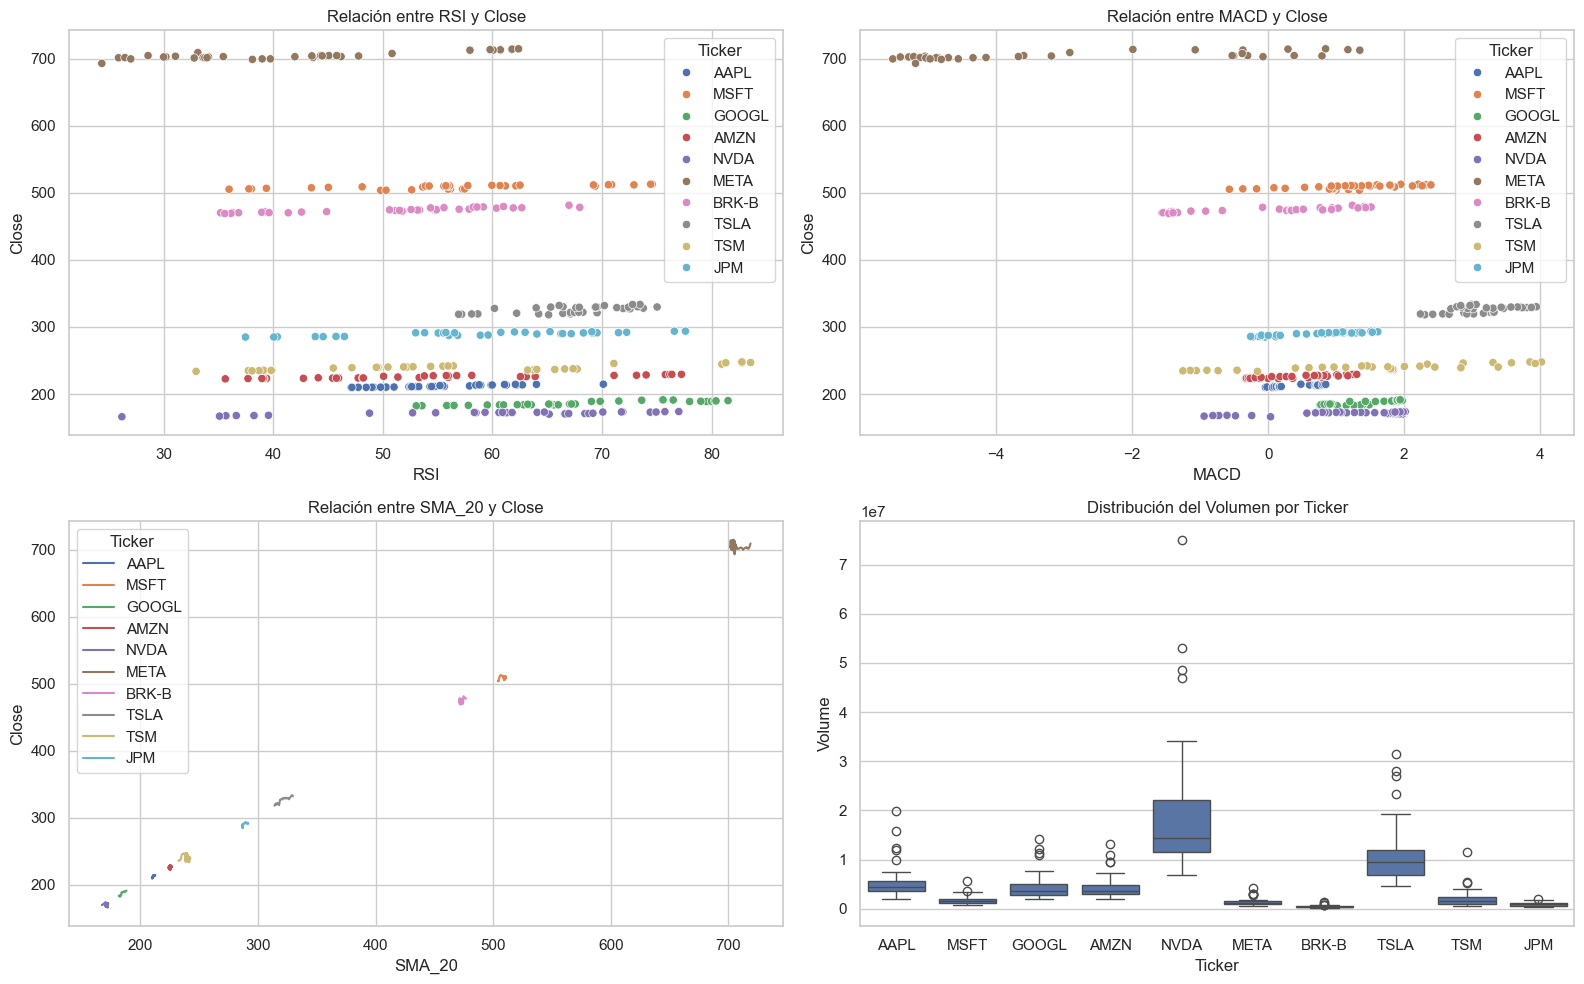

In [71]:
data = DataFetcher()
data.visualize_relationships()

In [65]:
class traditionalAgent:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.broker = broker
        self.whiteboard = whiteboard
        self.data_fetcher = data_fetcher
        self.df = None
        self.broker.subscribe(self.group_traditional)

    def set_dataframe(self, df):
        self.df = df

    def group_traditional(self, data):
        idx = self.data_fetcher.index
        if idx < 2 or self.df is None:
            self.whiteboard.write('trad_pred', data['Close'])
            return

        # Filtrar histórico por ticker actual
        df_hist = self.df.iloc[:idx].copy()
        df_hist = df_hist[df_hist['Ticker'] == data['Ticker']].reset_index(drop=True)

        if len(df_hist) < 10:
            self.whiteboard.write('trad_pred', data['Close'])
            return

        # Columnas predictoras
        features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'SMA_20', 'MACD']

        # Objetivo: Close futuro (t+1)
        df_hist['Close_Future'] = df_hist['Close'].shift(-1)
        df_hist = df_hist.fillna(method='ffill')

        try:
            X = df_hist[features]
            y = df_hist['Close_Future']
            current_features = np.array([data[f] for f in features]).reshape(1, -1)

            # pred1: Regresión lineal multivariable
            model1 = LinearRegression()
            model1.fit(X, y)
            pred1 = model1.predict(current_features)[0]

            # pred2: Gradient Boosting multivariable
            model2 = GradientBoostingRegressor()
            model2.fit(X, y)
            pred2 = model2.predict(current_features)[0]

        except Exception:
            pred1 = pred2 = data['Close']

        avg = (pred1 + pred2) / 2
        self.whiteboard.write('trad_pred', avg)

In [66]:
class agenteIA:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.broker = broker
        self.whiteboard = whiteboard
        self.broker.subscribe(self.group_ai)
        self.data_fetcher = data_fetcher

    def group_ai(self, data):
        if self.data_fetcher.index > 1:
            last_close = df.loc[self.data_fetcher.index - 2]['Close']
        else:
            last_close = data['Close']
        pred1 = last_close * random.uniform(0.95, 1.05)
        pred2 = last_close * random.uniform(0.95, 1.05)
        avg = (pred1 + pred2) / 2
        self.whiteboard.write('ai_pred', avg)
        
    def set_dataframe():
        self.df = self.df

In [ ]:
# ----------------------------
# MarketEnvironment
# ----------------------------
class MarketEnvironment:
    def __init__(self):
        #Aqui tendiramos es que llamar la funcion
        self.df = DataFetcher().fetch_and_process_data()
        self.broker = PubSubBroker()
        self.whiteboard = Whiteboard()
        self.histories = {}  # Diccionario para almacenar cada empresa

        # Agentes de predicción
        self.agentsTraditional = traditionalAgent(self.broker, self.whiteboard, self.data_fetcher)
        self.agentsIA = agenteIA(self.broker, self.whiteboard, self.data_fetcher)
        self.agentsTraditional.set_dataframe(df)

        # Suscribir los grupos de agentes al broker
        self.broker.subscribe(self.agentsTraditional.group_traditional)
        self.broker.subscribe(self.agentsIA.group_ai)

    def run(self):
        tickers = self.df['Ticker'].unique().tolist()

        for ticker in tickers:
            print(f"Iniciando simulación para {ticker}...")

            df_ticker = self.df[self.df['Ticker'] == ticker].reset_index(drop=True)
            self.data_fetcher = DataFetcher(df_ticker)
            self.agentsTraditional.set_dataframe(df_ticker)

            self.histories[ticker] = pd.DataFrame(columns=['Datetime', 'Real_Close', 'Trad_Prediction', 'AI_Prediction'])

            # Primer paso: hacer la primera predicción (usando t)
            if not self.data_fetcher.has_next():
                continue
            current_data = self.data_fetcher.fetch_data()
            self.whiteboard.clear()
            self.broker.publish(current_data)
            last_prediction = self.whiteboard.read()  # ← esto reemplaza a last_data

            while self.data_fetcher.has_next():
                current_data = self.data_fetcher.fetch_data()

                # Guardar la predicción previa (hecha en t) contra el valor real de t+1
                self.histories[ticker].loc[len(self.histories[ticker])] = [
                    current_data['Datetime'],
                    current_data['Close'],
                    last_prediction.get('trad_pred', current_data['Close']),
                    last_prediction.get('ai_pred', current_data['Close'])
                ]

                print(
                    f"[{current_data['Datetime']}] {ticker} | "
                    f"Real: {current_data['Close']:.2f} | "
                    f"Tradicional: {last_prediction.get('trad_pred', current_data['Close']):.2f} | "
                    f"IA: {last_prediction.get('ai_pred', current_data['Close']):.2f}"
                )

                # Hacer predicción para t+2 usando datos de t+1
                self.whiteboard.clear()
                self.broker.publish(current_data)
                last_prediction = self.whiteboard.read()

            self.plot_graph(ticker)
            self.histories[ticker].to_excel(f"simulacion_{ticker}.xlsx", index=False)
            print(f"✔ Terminó {ticker}")


    def plot_graph(self, ticker):
        history = self.histories[ticker]

        # Ignorar el primer punto
        history = history.iloc[1:]

        plt.figure(figsize=(12,5))
        plt.plot(history['Datetime'], history['Real_Close'], label='Precio Real', marker='o')
        plt.plot(history['Datetime'], history['Trad_Prediction'], label='Predicción Tradicional', linestyle='--', marker='x')
        plt.plot(history['Datetime'], history['AI_Prediction'], label='Predicción IA', linestyle='-.', marker='s')
        plt.legend()
        plt.title(f'Simulación Multiagente - {ticker}')
        plt.xlabel('Tiempo')
        plt.ylabel('Precio de Cierre')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Iniciando simulación para AAPL...
[2025-07-16 14:30:00] AAPL | Real: 210.12 | Tradicional: 212.09 | IA: 213.58
[2025-07-16 15:30:00] AAPL | Real: 209.59 | Tradicional: 210.12 | IA: 217.97
[2025-07-16 16:30:00] AAPL | Real: 210.35 | Tradicional: 209.59 | IA: 205.66
[2025-07-16 17:30:00] AAPL | Real: 210.04 | Tradicional: 210.35 | IA: 206.64
[2025-07-16 18:30:00] AAPL | Real: 210.32 | Tradicional: 210.04 | IA: 206.11
[2025-07-16 19:30:00] AAPL | Real: 210.22 | Tradicional: 210.32 | IA: 211.23
[2025-07-17 13:30:00] AAPL | Real: 209.95 | Tradicional: 210.22 | IA: 213.52
[2025-07-17 14:30:00] AAPL | Real: 210.44 | Tradicional: 209.95 | IA: 216.22
[2025-07-17 15:30:00] AAPL | Real: 211.39 | Tradicional: 210.44 | IA: 205.88
[2025-07-17 16:30:00] AAPL | Real: 210.96 | Tradicional: 211.39 | IA: 205.34
[2025-07-17 17:30:00] AAPL | Real: 211.28 | Tradicional: 210.96 | IA: 204.29
[2025-07-17 18:30:00] AAPL | Real: 210.99 | Tradicional: 211.28 | IA: 208.13
[2025-07-17 19:30:00] AAPL | Real: 210.06 

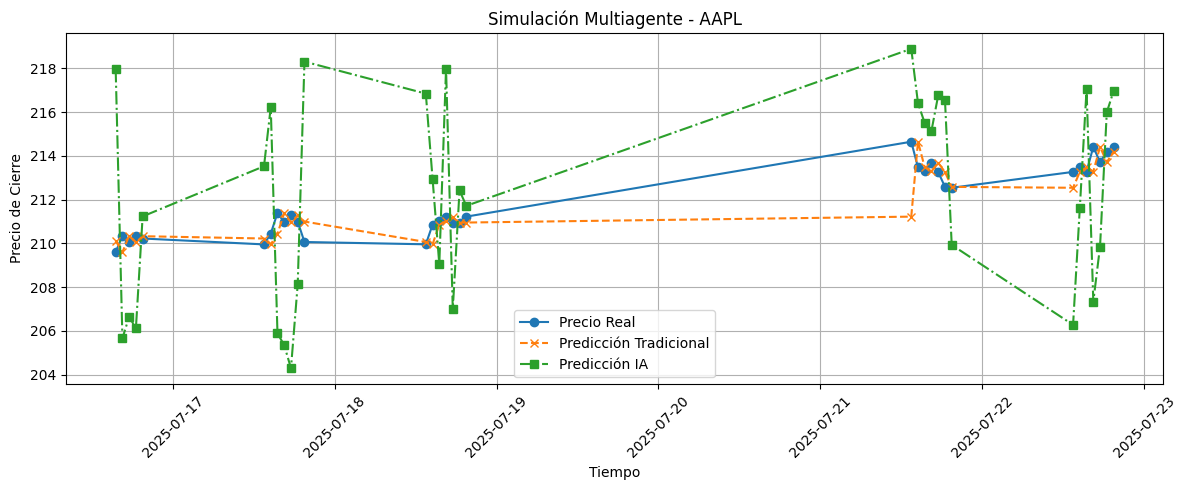

✔ Terminó AAPL
Iniciando simulación para MSFT...
[2025-07-16 14:30:00] MSFT | Real: 504.45 | Tradicional: 503.72 | IA: 516.85
[2025-07-16 15:30:00] MSFT | Real: 503.89 | Tradicional: 504.45 | IA: 514.06
[2025-07-16 16:30:00] MSFT | Real: 505.45 | Tradicional: 503.89 | IA: 489.00
[2025-07-16 17:30:00] MSFT | Real: 505.77 | Tradicional: 505.45 | IA: 497.98
[2025-07-16 18:30:00] MSFT | Real: 505.82 | Tradicional: 505.77 | IA: 501.08
[2025-07-16 19:30:00] MSFT | Real: 505.53 | Tradicional: 505.82 | IA: 517.87
[2025-07-17 13:30:00] MSFT | Real: 510.08 | Tradicional: 505.53 | IA: 507.11
[2025-07-17 14:30:00] MSFT | Real: 511.89 | Tradicional: 510.08 | IA: 517.42
[2025-07-17 15:30:00] MSFT | Real: 512.84 | Tradicional: 511.89 | IA: 507.14
[2025-07-17 16:30:00] MSFT | Real: 512.82 | Tradicional: 512.84 | IA: 505.32
[2025-07-17 17:30:00] MSFT | Real: 512.14 | Tradicional: 512.82 | IA: 508.02
[2025-07-17 18:30:00] MSFT | Real: 512.09 | Tradicional: 512.14 | IA: 506.57
[2025-07-17 19:30:00] MSFT 

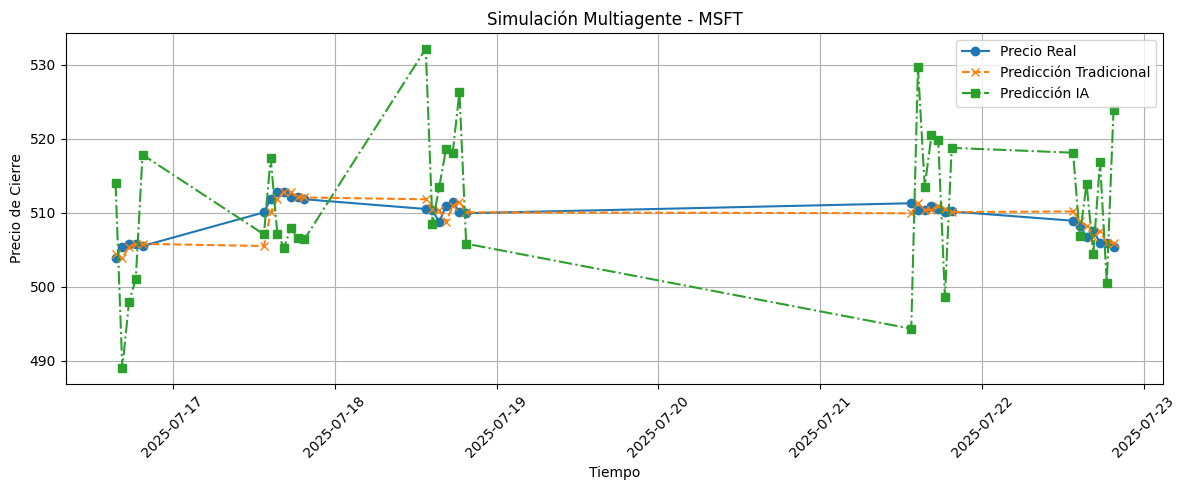

✔ Terminó MSFT
Iniciando simulación para GOOGL...
[2025-07-16 14:30:00] GOOGL | Real: 183.95 | Tradicional: 183.84 | IA: 187.65
[2025-07-16 15:30:00] GOOGL | Real: 183.00 | Tradicional: 183.95 | IA: 187.52
[2025-07-16 16:30:00] GOOGL | Real: 183.99 | Tradicional: 183.00 | IA: 178.85
[2025-07-16 17:30:00] GOOGL | Real: 183.89 | Tradicional: 183.99 | IA: 181.78
[2025-07-16 18:30:00] GOOGL | Real: 183.13 | Tradicional: 183.89 | IA: 180.92
[2025-07-16 19:30:00] GOOGL | Real: 182.91 | Tradicional: 183.13 | IA: 179.63
[2025-07-17 13:30:00] GOOGL | Real: 182.48 | Tradicional: 182.91 | IA: 188.48
[2025-07-17 14:30:00] GOOGL | Real: 182.40 | Tradicional: 182.48 | IA: 176.16
[2025-07-17 15:30:00] GOOGL | Real: 182.88 | Tradicional: 182.40 | IA: 186.99
[2025-07-17 16:30:00] GOOGL | Real: 182.99 | Tradicional: 182.88 | IA: 183.21
[2025-07-17 17:30:00] GOOGL | Real: 183.74 | Tradicional: 182.99 | IA: 183.93
[2025-07-17 18:30:00] GOOGL | Real: 183.81 | Tradicional: 183.74 | IA: 186.69
[2025-07-17 19

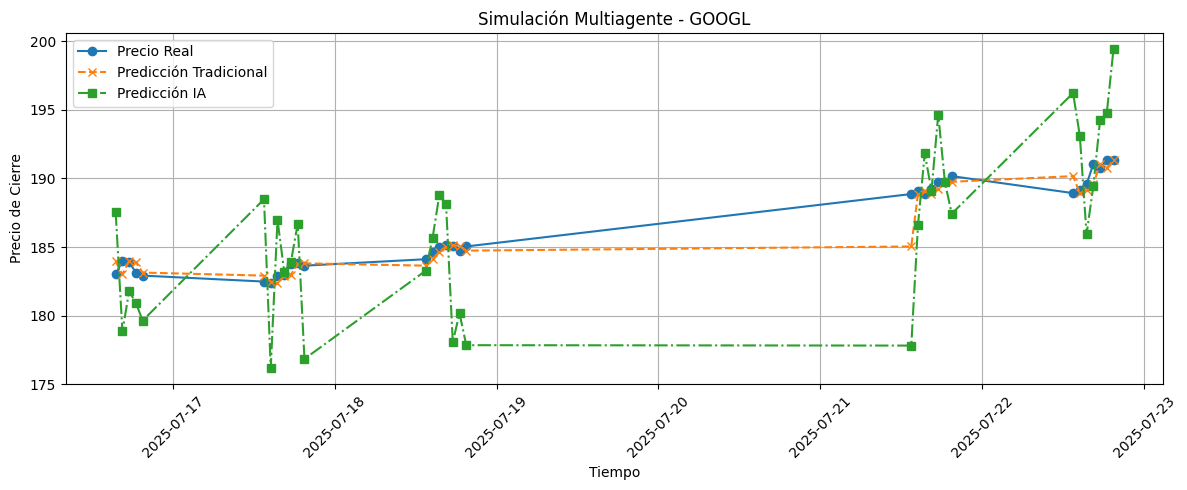

✔ Terminó GOOGL
Iniciando simulación para AMZN...
[2025-07-16 14:30:00] AMZN | Real: 224.21 | Tradicional: 225.28 | IA: 221.61
[2025-07-16 15:30:00] AMZN | Real: 223.36 | Tradicional: 224.21 | IA: 228.78
[2025-07-16 16:30:00] AMZN | Real: 223.03 | Tradicional: 223.36 | IA: 215.03
[2025-07-16 17:30:00] AMZN | Real: 223.20 | Tradicional: 223.03 | IA: 217.61
[2025-07-16 18:30:00] AMZN | Real: 223.19 | Tradicional: 223.20 | IA: 223.21
[2025-07-16 19:30:00] AMZN | Real: 223.17 | Tradicional: 223.19 | IA: 218.01
[2025-07-17 13:30:00] AMZN | Real: 222.62 | Tradicional: 223.17 | IA: 221.67
[2025-07-17 14:30:00] AMZN | Real: 223.76 | Tradicional: 222.62 | IA: 229.15
[2025-07-17 15:30:00] AMZN | Real: 223.68 | Tradicional: 223.76 | IA: 220.32
[2025-07-17 16:30:00] AMZN | Real: 223.72 | Tradicional: 223.68 | IA: 227.16
[2025-07-17 17:30:00] AMZN | Real: 223.94 | Tradicional: 223.72 | IA: 227.45
[2025-07-17 18:30:00] AMZN | Real: 223.99 | Tradicional: 223.94 | IA: 228.02
[2025-07-17 19:30:00] AMZN

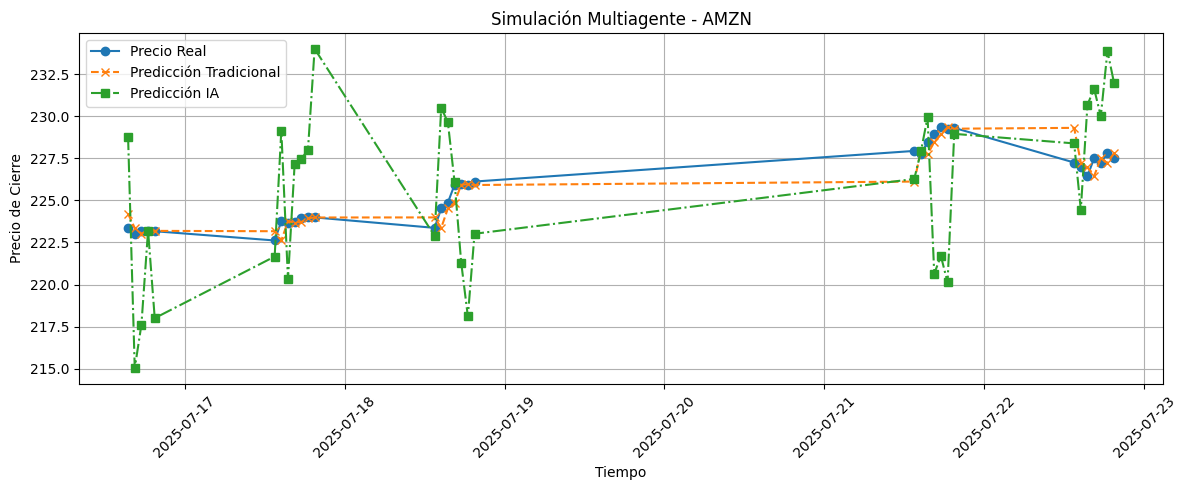

✔ Terminó AMZN
Iniciando simulación para NVDA...
[2025-07-16 14:30:00] NVDA | Real: 170.38 | Tradicional: 169.96 | IA: 162.89
[2025-07-16 15:30:00] NVDA | Real: 170.40 | Tradicional: 170.38 | IA: 168.91
[2025-07-16 16:30:00] NVDA | Real: 170.90 | Tradicional: 170.40 | IA: 170.47
[2025-07-16 17:30:00] NVDA | Real: 171.01 | Tradicional: 170.90 | IA: 169.21
[2025-07-16 18:30:00] NVDA | Real: 170.78 | Tradicional: 171.01 | IA: 172.85
[2025-07-16 19:30:00] NVDA | Real: 171.34 | Tradicional: 170.78 | IA: 170.44
[2025-07-17 13:30:00] NVDA | Real: 172.93 | Tradicional: 171.34 | IA: 175.37
[2025-07-17 14:30:00] NVDA | Real: 173.12 | Tradicional: 172.93 | IA: 175.00
[2025-07-17 15:30:00] NVDA | Real: 173.86 | Tradicional: 173.12 | IA: 181.17
[2025-07-17 16:30:00] NVDA | Real: 173.72 | Tradicional: 173.86 | IA: 175.45
[2025-07-17 17:30:00] NVDA | Real: 173.30 | Tradicional: 173.72 | IA: 173.12
[2025-07-17 18:30:00] NVDA | Real: 173.29 | Tradicional: 173.30 | IA: 170.47
[2025-07-17 19:30:00] NVDA 

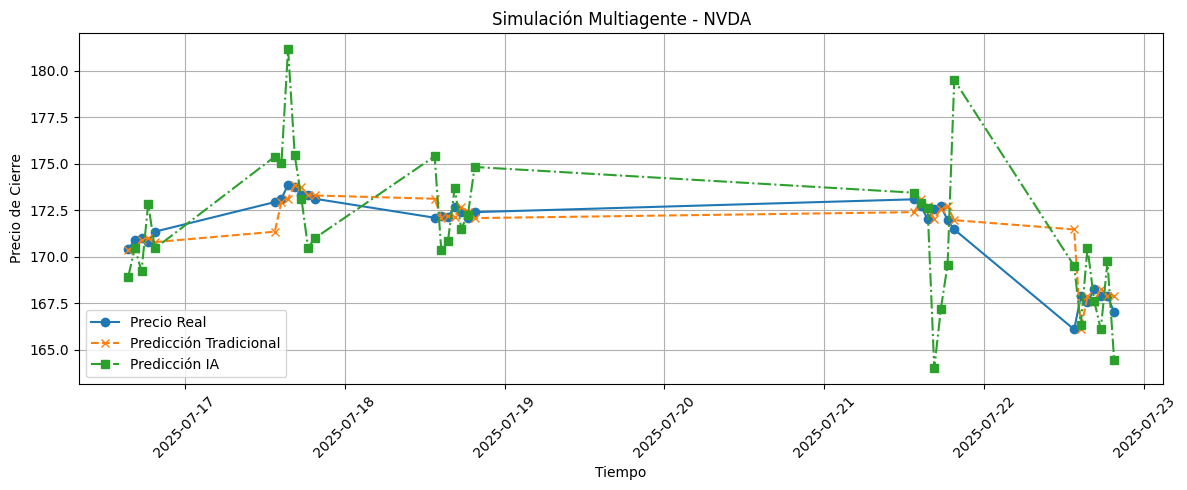

✔ Terminó NVDA
Iniciando simulación para META...
[2025-07-16 14:30:00] META | Real: 704.66 | Tradicional: 709.21 | IA: 736.88
[2025-07-16 15:30:00] META | Real: 701.45 | Tradicional: 704.66 | IA: 700.62
[2025-07-16 16:30:00] META | Real: 701.70 | Tradicional: 701.45 | IA: 672.48
[2025-07-16 17:30:00] META | Real: 703.68 | Tradicional: 701.70 | IA: 679.74
[2025-07-16 18:30:00] META | Real: 702.83 | Tradicional: 703.68 | IA: 698.90
[2025-07-16 19:30:00] META | Real: 702.64 | Tradicional: 702.83 | IA: 706.40
[2025-07-17 13:30:00] META | Real: 699.73 | Tradicional: 702.64 | IA: 696.90
[2025-07-17 14:30:00] META | Real: 702.64 | Tradicional: 699.73 | IA: 701.69
[2025-07-17 15:30:00] META | Real: 703.22 | Tradicional: 702.64 | IA: 710.57
[2025-07-17 16:30:00] META | Real: 701.78 | Tradicional: 703.22 | IA: 716.38
[2025-07-17 17:30:00] META | Real: 701.14 | Tradicional: 701.78 | IA: 698.57
[2025-07-17 18:30:00] META | Real: 701.50 | Tradicional: 701.14 | IA: 693.18
[2025-07-17 19:30:00] META 

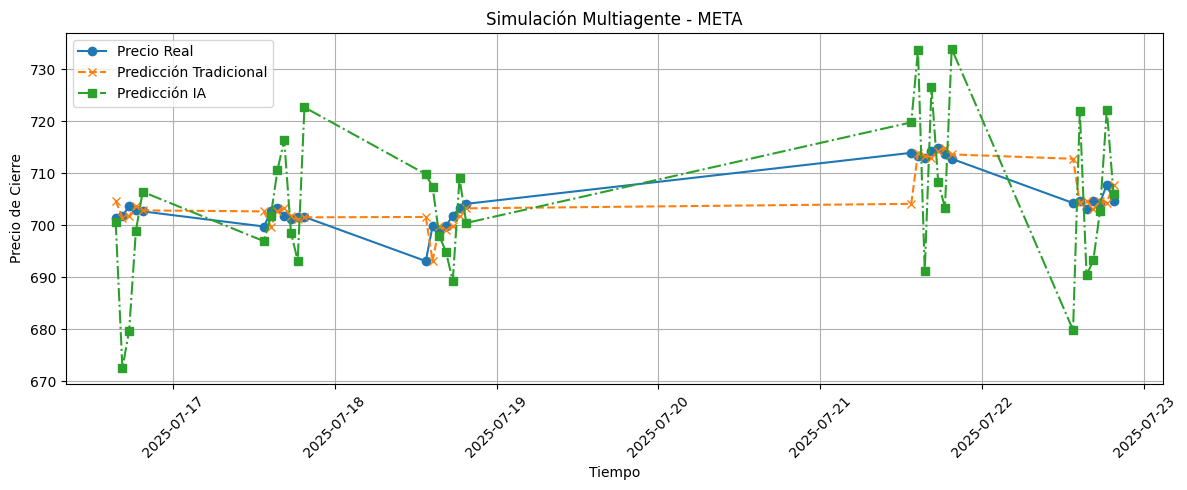

✔ Terminó META
Iniciando simulación para BRK-B...
[2025-07-16 14:30:00] BRK-B | Real: 470.67 | Tradicional: 471.65 | IA: 455.25
[2025-07-16 15:30:00] BRK-B | Real: 470.29 | Tradicional: 470.67 | IA: 472.37
[2025-07-16 16:30:00] BRK-B | Real: 471.01 | Tradicional: 470.29 | IA: 471.32
[2025-07-16 17:30:00] BRK-B | Real: 470.36 | Tradicional: 471.01 | IA: 481.79
[2025-07-16 18:30:00] BRK-B | Real: 471.99 | Tradicional: 470.36 | IA: 458.23
[2025-07-16 19:30:00] BRK-B | Real: 471.35 | Tradicional: 471.99 | IA: 483.56
[2025-07-17 13:30:00] BRK-B | Real: 470.48 | Tradicional: 471.35 | IA: 490.91
[2025-07-17 14:30:00] BRK-B | Real: 469.35 | Tradicional: 470.48 | IA: 483.30
[2025-07-17 15:30:00] BRK-B | Real: 469.16 | Tradicional: 469.35 | IA: 482.06
[2025-07-17 16:30:00] BRK-B | Real: 470.27 | Tradicional: 469.16 | IA: 479.92
[2025-07-17 17:30:00] BRK-B | Real: 472.76 | Tradicional: 470.27 | IA: 473.29
[2025-07-17 18:30:00] BRK-B | Real: 472.74 | Tradicional: 472.76 | IA: 467.19
[2025-07-17 19

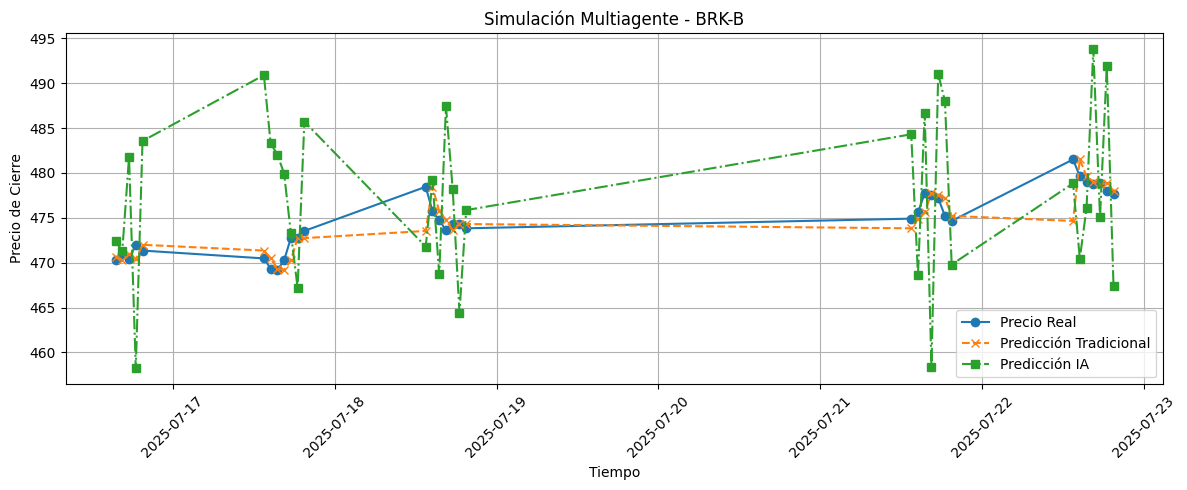

✔ Terminó BRK-B
Iniciando simulación para TSLA...
[2025-07-16 14:30:00] TSLA | Real: 319.51 | Tradicional: 318.18 | IA: 321.02
[2025-07-16 15:30:00] TSLA | Real: 321.20 | Tradicional: 319.51 | IA: 318.11
[2025-07-16 16:30:00] TSLA | Real: 320.20 | Tradicional: 321.20 | IA: 312.70
[2025-07-16 17:30:00] TSLA | Real: 319.48 | Tradicional: 320.20 | IA: 332.42
[2025-07-16 18:30:00] TSLA | Real: 322.03 | Tradicional: 319.48 | IA: 314.05
[2025-07-16 19:30:00] TSLA | Real: 321.67 | Tradicional: 322.03 | IA: 332.90
[2025-07-17 13:30:00] TSLA | Real: 321.89 | Tradicional: 321.67 | IA: 318.16
[2025-07-17 14:30:00] TSLA | Real: 322.12 | Tradicional: 321.89 | IA: 324.33
[2025-07-17 15:30:00] TSLA | Real: 320.53 | Tradicional: 322.12 | IA: 317.78
[2025-07-17 16:30:00] TSLA | Real: 319.46 | Tradicional: 320.53 | IA: 319.05
[2025-07-17 17:30:00] TSLA | Real: 319.01 | Tradicional: 319.46 | IA: 314.30
[2025-07-17 18:30:00] TSLA | Real: 318.93 | Tradicional: 319.01 | IA: 316.21
[2025-07-17 19:30:00] TSLA

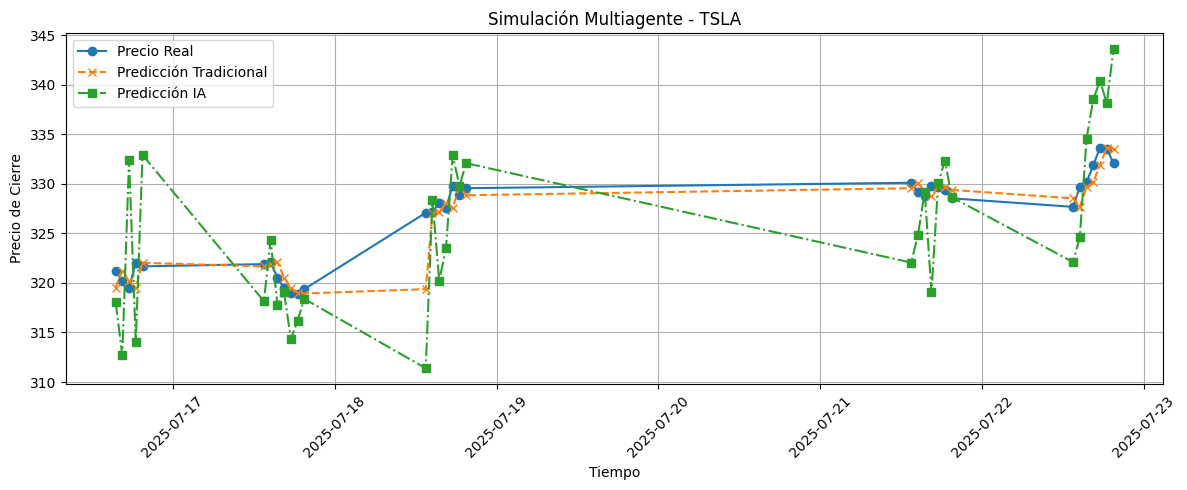

✔ Terminó TSLA
Iniciando simulación para TSM...
[2025-07-16 14:30:00] TSM | Real: 235.80 | Tradicional: 235.90 | IA: 242.02
[2025-07-16 15:30:00] TSM | Real: 236.57 | Tradicional: 235.80 | IA: 240.93
[2025-07-16 16:30:00] TSM | Real: 237.24 | Tradicional: 236.57 | IA: 240.12
[2025-07-16 17:30:00] TSM | Real: 236.64 | Tradicional: 237.24 | IA: 239.57
[2025-07-16 18:30:00] TSM | Real: 237.42 | Tradicional: 236.64 | IA: 238.52
[2025-07-16 19:30:00] TSM | Real: 237.66 | Tradicional: 237.42 | IA: 237.05
[2025-07-17 13:30:00] TSM | Real: 244.58 | Tradicional: 237.66 | IA: 232.97
[2025-07-17 14:30:00] TSM | Real: 246.24 | Tradicional: 244.58 | IA: 234.79
[2025-07-17 15:30:00] TSM | Real: 246.99 | Tradicional: 246.24 | IA: 252.74
[2025-07-17 16:30:00] TSM | Real: 246.56 | Tradicional: 246.99 | IA: 237.25
[2025-07-17 17:30:00] TSM | Real: 247.80 | Tradicional: 246.56 | IA: 239.58
[2025-07-17 18:30:00] TSM | Real: 247.82 | Tradicional: 247.80 | IA: 237.13
[2025-07-17 19:30:00] TSM | Real: 245.55

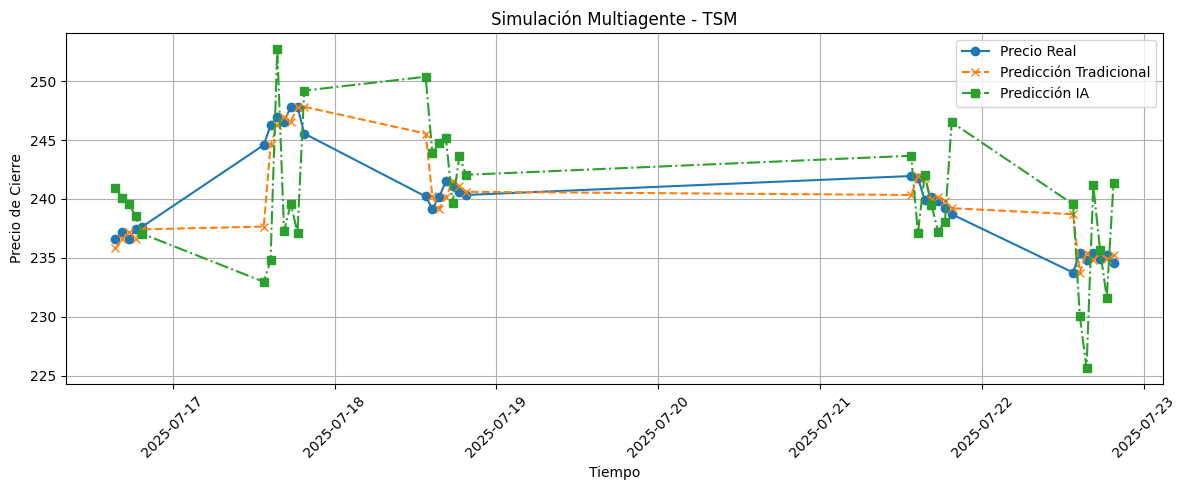

✔ Terminó TSM
Iniciando simulación para JPM...
[2025-07-16 14:30:00] JPM | Real: 284.95 | Tradicional: 285.43 | IA: 278.53
[2025-07-16 15:30:00] JPM | Real: 285.66 | Tradicional: 284.95 | IA: 276.94
[2025-07-16 16:30:00] JPM | Real: 285.89 | Tradicional: 285.66 | IA: 278.23
[2025-07-16 17:30:00] JPM | Real: 285.01 | Tradicional: 285.89 | IA: 281.19
[2025-07-16 18:30:00] JPM | Real: 285.54 | Tradicional: 285.01 | IA: 286.84
[2025-07-16 19:30:00] JPM | Real: 285.78 | Tradicional: 285.54 | IA: 283.56
[2025-07-17 13:30:00] JPM | Real: 287.70 | Tradicional: 285.78 | IA: 285.86
[2025-07-17 14:30:00] JPM | Real: 287.42 | Tradicional: 287.70 | IA: 295.14
[2025-07-17 15:30:00] JPM | Real: 287.93 | Tradicional: 287.42 | IA: 276.02
[2025-07-17 16:30:00] JPM | Real: 287.46 | Tradicional: 287.93 | IA: 298.33
[2025-07-17 17:30:00] JPM | Real: 289.93 | Tradicional: 287.46 | IA: 287.43
[2025-07-17 18:30:00] JPM | Real: 289.49 | Tradicional: 289.93 | IA: 286.76
[2025-07-17 19:30:00] JPM | Real: 290.06 

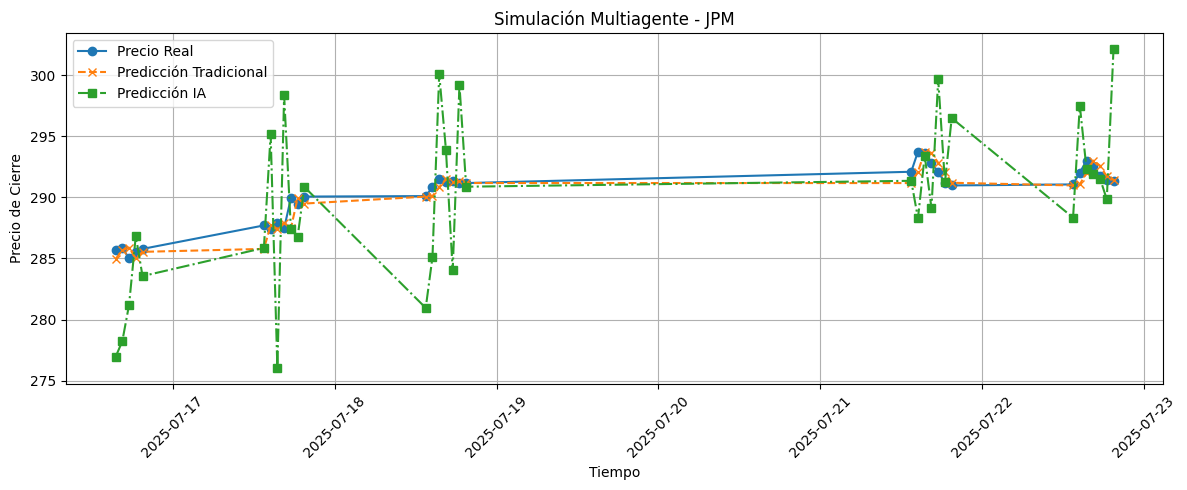

✔ Terminó JPM


In [68]:
# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    # Cargar datos
    #df = pd.read_excel("historico_top10_indicadores_completos.xlsx")
    env = MarketEnvironment()
    env.run()